Import zależności

In [2]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import sklearn
import sklearn.datasets
import sklearn.model_selection
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder

2024-09-04 23:28:26.376957: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 23:28:26.838047: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-04 23:28:27.305088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 23:28:27.673261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 23:28:27.778733: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-04 23:28:28.367204: I tensorflow/core/platform/cpu_feature_gu

Pobranie danych z artykułu 

In [3]:
origin_data = pd.read_csv('../Datasets/biomass-production-data.csv')
origin_data.info()
origin_data.head(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Run                  30 non-null     int64  
 1   LightIntensity       30 non-null     int64  
 2   Photoperiod          30 non-null     object 
 3   Temperature          30 non-null     int64  
 4   Initial pH           30 non-null     float64
 5   BiomassProductivity  30 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 1.5+ KB


,Run,LightIntensity,Photoperiod,Temperature,Initial pH,BiomassProductivity
0,1,116,24:00,28,8.0,185.6
1,2,165,19:05,22,6.5,140.6
2,3,66,19:05,34,6.5,135.0


Wywalamy niepotrzebna kolumne Run order oraz musimy napisac metoda konwertujac wartosc "photoperiod" do wartosci numerycznej


In [4]:
data = origin_data.drop('Run', axis=1)

def encode_photoperiod(x):
    minutes = int(x.split(":")[0]) * 60 + int(x.split(":")[1])
    return minutes

def decode_photoperiod(x):
    hours = x // 60
    minutes = x % 60
    return f"{hours}:{minutes}"

# test_value = data['Photoperiod'][0]
# print(f"Test value: {test_value}")
# encoded_test_value = encode_photoperiod(test_value)
# print(f"Encoded test value: {encoded_test_value}")
# decoded_test_value = decode_photoperiod(encoded_test_value)
# print(f"Decoded test value: {decoded_test_value}")

data.head(3)

,LightIntensity,Photoperiod,Temperature,Initial pH,BiomassProductivity
0,116,24:00,28,8.0,185.6
1,165,19:05,22,6.5,140.6
2,66,19:05,34,6.5,135.0


Podmieniamy wartosc photoperiod na wartosc numeryczna

In [5]:
# update the Photoperiod column with the encoded values
data['Photoperiod'] = data['Photoperiod'].apply(encode_photoperiod)

data.head(3)

,LightIntensity,Photoperiod,Temperature,Initial pH,BiomassProductivity
0,116,1440,28,8.0,185.6
1,165,1145,22,6.5,140.6
2,66,1145,34,6.5,135.0


Normalizowania danych

In [15]:
# implement method for normalizing the data only positive values
def normalize(x):
    x_max = x.max()
    x_min = x.min()
    return (x - x_min) / (x_max - x_min)

# normalize the data for each column
norm_data = data.copy()
for column in data.columns:
    norm_data[column] = normalize(data[column])


norm_data.head(3)

,LightIntensity,Photoperiod,Temperature,Initial pH,BiomassProductivity
0,0.500000,1.00,0.50,0.50,0.692343
1,0.747475,0.75,0.25,0.25,0.487238
2,0.247475,0.75,0.75,0.25,0.461714


Metoda przeliczajaca z wartosci znormalizowanej do zwyklej

In [7]:
# method covert from normalized data to original data
def denormalize(data, norm_data):
    return (norm_data * data.std()) + data.mean()

# test the denormalize method
test_value = data['BiomassProductivity'][0]
print(f"Test value: {test_value}")
norm_test_value = norm_data['BiomassProductivity'][0]
print(f"Normalized test value: {norm_test_value}")
denorm_test_value = denormalize(data['BiomassProductivity'], norm_test_value)
print(f"Denormalized test value: {denorm_test_value}")



Test value: 185.6
Normalized test value: 0.5426128219300366
Denormalized test value: 185.6


In [ ]:
Wlasnie widze ze moglem uzyc LabelEncoder zamiast pisac wlasne metody do kodowania i dekodowania danych.


In [26]:
# use label encoder to encode the data
encoder = LabelEncoder()
encoded_data = data.copy()
for column in data.columns:
    encoded_data[column] = encoder.fit(data[column])

encoded_data.head(3)



,Light Intensity,Photoperiod,Temperature,Initial pH,Biomass productivity
0,LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder()
1,LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder()
2,LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder(),LabelEncoder()


In [ ]:
Konwertuejmy dane do datasetu TensorFlow

In [37]:
train, test = sklearn.model_selection.train_test_split(norm_data, test_size=0.2, shuffle=True, random_state=42)

train_X = train.drop('BiomassProductivity', axis=1)
train_y = train['BiomassProductivity']

test_X = test.drop('BiomassProductivity', axis=1)
test_y = test['BiomassProductivity']


Tworzymy pierwszy model z uzyciem 2 warstw ukrytych. Warstawa wejściowa i wyściowa są zawsze takie same, roznice w modelach beda tylko w ilosci ukrytych, dlatego na start sobie zdefiniuje input i output layer

In [35]:
input_layer = tf.keras.layers.Dense(4) # 4 poniewaz mamy 4 cechy
output_layer = tf.keras.layers.Dense(1, activation='sigmoid') # 1 poniewaz mamy 1 wartosc do przewidzenia



In [36]:
model_1 = tf.keras.Sequential([
    input_layer,
    tf.keras.layers.Dense(12),
    output_layer
])

model_1.compile(optimizer=tf.keras.optimizers.SGD(), loss=tf.keras.losses.mae, metrics=['accuracy'])

history_1 = model_1.fit(train_X, train_y, epochs=10)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step - accuracy: 0.2500 - loss: 0.2658
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.2658
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2500 - loss: 0.2658
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2500 - loss: 0.2657
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.2657
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 0.2657
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.2657
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2500 - loss: 0.2656
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 0.2656
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2500 - loss: 0.2656


In [70]:
predictions = model_1.predict(test_X, verbose=0)
predictions = predictions.flatten()
predictions_values = denormalize(data['BiomassProductivity'], predictions)

real_values = denormalize(data['BiomassProductivity'], test_y).values


In [74]:
def value_diff(prediction, real_value):
    # return the difference between the predicted and real values in percentage
    return abs(((prediction - real_value) / real_value * 100).round(2))


for i in range(len(predictions_values)):
    print(f"Predicted value: {predictions_values[i]}, Real value: {real_values[i]}, Difference: {value_diff(predictions_values[i], real_values[i])}%")

Predicted value: 185.46734619140625, Real value: 158.51484675917126, Difference: 17.0%
Predicted value: 184.60325622558594, Real value: 219.72480657264398, Difference: 15.98%
Predicted value: 184.25503540039062, Real value: 150.86360178248717, Difference: 22.13%
Predicted value: 182.5838623046875, Real value: 154.70622703744408, Difference: 18.02%
Predicted value: 184.6076202392578, Real value: 187.21551680504405, Difference: 1.39%
Predicted value: 186.6142120361328, Real value: 162.35747201412818, Difference: 14.94%


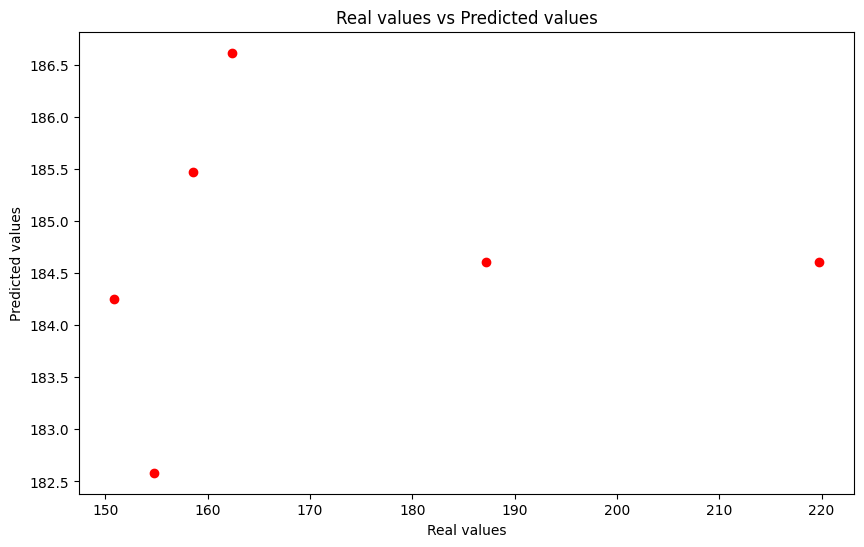

In [55]:


# Compare the real values with the predicted values on chart
plt.figure(figsize=(10, 6))
plt.scatter(real_values, predictions_values, c='r')
# plt.plot([real_values.min(), real_values.max()], [real_values.min(), real_values.max()], 'k--', lw=4)
plt.xlabel('Real values')
plt.ylabel('Predicted values')
plt.title('Real values vs Predicted values')
plt.show()
